# CNN + Masks (UNET)

This notebook uses the model from 
https://ieeexplore.ieee.org/abstract/document/9057809

In addition we add segmentation masks from unet to a 4. channel of the images.
The input is therefore R - G - B - Cutout (grayscale img).

In [1]:
import pandas as pd
import math
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from pathlib import Path
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import activations
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, Callback, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, AveragePooling2D, Conv2D, MaxPool2D, Activation, GlobalAveragePooling2D
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from generators import MaskPredDataGenerator

In [2]:
# Config
IMG_SIZE = 256
BATCH_SIZE=32
train_path = 'data/chest-x-ray/train/'
test_path = 'data/chest-x-ray/test/'
val_path = 'data/chest-x-ray/val/'

train_mask_path = 'data/chest-x-ray/masks/train/'
val_mask_path = 'data/chest-x-ray/masks/val/'
test_mask_path = 'data/chest-x-ray/masks/test/'

In [3]:
np.random.seed(200)
tf.random.set_seed(200)

## 1 Data preparation

In [4]:
def load_images_from_folder(img_folder, masks_folder):
    tmp_df = pd.DataFrame(columns = ['img', 'label', 'mask'])  
    # IMGs
    for label_folder in os.listdir(img_folder):
        for filename in os.listdir(img_folder + '/' + label_folder):
            img_path = str(img_folder)+str(label_folder)+'/'+str(filename)
            # normal file ending is jpEg...
            filename_wo_ending = filename.split('.jpeg')[0]
            mask_path = str(masks_folder)+str(label_folder)+'/'+str(filename_wo_ending) + '_predmask.jpg'

            if img_path is not None:
                tmp_df = tmp_df.append({'img': img_path, 'label': label_folder, 'mask': mask_path}, ignore_index=True)

    return tmp_df

In [5]:
df_train = load_images_from_folder(train_path, train_mask_path)
df_val = load_images_from_folder(val_path, val_mask_path)
df_test = load_images_from_folder(test_path, test_mask_path)

In [6]:
# Shuffle
df_train = df_train.sample(frac=1, random_state=200).reset_index(drop=True)
df_val = df_val.sample(frac=1, random_state=200).reset_index(drop=True)
df_test = df_test.sample(frac=1, random_state=200).reset_index(drop=True)

In [7]:
print('=== Data: ===')
print('Train:', len(df_train))
print('Val:', len(df_val))
print('Test:', len(df_test))

=== Data: ===
Train: 5216
Val: 116
Test: 524


In [8]:
def replace_by_binary_class(df, to_replace, value):
    return df.replace(to_replace=to_replace, value=value)

In [9]:
df_train = replace_by_binary_class(df_train, 'NORMAL', 0)
df_train = replace_by_binary_class(df_train, 'PNEUMONIA', 1)

df_val = replace_by_binary_class(df_val, 'NORMAL', 0)
df_val = replace_by_binary_class(df_val, 'PNEUMONIA', 1)

df_test = replace_by_binary_class(df_test, 'NORMAL', 0)
df_test = replace_by_binary_class(df_test, 'PNEUMONIA', 1)

In [10]:
df_train.head()

,img,label,mask
0,data/chest-x-ray/train/PNEUMONIA/person307_bac...,1,data/chest-x-ray/masks/aaa/train/PNEUMONIA/per...
1,data/chest-x-ray/train/PNEUMONIA/person1400_ba...,1,data/chest-x-ray/masks/aaa/train/PNEUMONIA/per...
2,data/chest-x-ray/train/PNEUMONIA/person1369_vi...,1,data/chest-x-ray/masks/aaa/train/PNEUMONIA/per...
3,data/chest-x-ray/train/PNEUMONIA/person488_vir...,1,data/chest-x-ray/masks/aaa/train/PNEUMONIA/per...
4,data/chest-x-ray/train/NORMAL/IM-0482-0001.jpeg,0,data/chest-x-ray/masks/aaa/train/NORMAL/IM-048...



## 2 Data generator

In [11]:
import imgaug as ia
import imgaug.augmenters as iaa

sometimes = lambda aug: iaa.Sometimes(0.5, aug)
seq_img = iaa.Sequential([
    sometimes(iaa.SigmoidContrast(gain=(3, 10), cutoff=(0.4, 0.6))),
    sometimes(iaa.Affine(
            rotate=(-10, 10),
            shear=(-10,10),
            scale={"x": (0.8, 1.1), "y": (0.8, 1.1)},
            translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}
    )),
    sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.15))),
], random_order=True)

class TrainDataGenerator4Channels(tf.keras.utils.Sequence):

    def __init__(self, df, augment, img_size, batch_size=8, shuffle=True):
        self.batch_size = batch_size
        self.df = df
        self.indices = self.df.index.tolist()
        self.shuffle = shuffle
        self.augment = augment
        self.img_size = img_size

    def __len__(self):
        return math.ceil(len(self.indices)/ self.batch_size) 
        # return len(self.indices) // self.batch_size

    def __getitem__(self, index):
        indexes = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch = [self.indices[k] for k in indexes]
        X, y = self.__get_data(batch)
        return np.array(X), np.array(y)

    def on_epoch_end(self):
        if self.shuffle == True:
            np.random.shuffle(self.indices)

    def __get_data(self, batch):
        X_img_paths = self.df['img']
        X_mask_paths = self.df['mask']
        X_imgs = []
        X_masks = []
        Y = self.df['label'].iloc[batch].to_numpy()

        for i in range(0, len(batch)):
            img = cv2.resize(cv2.imread(str(X_img_paths.iloc[batch[i]])), (self.img_size, self.img_size))
            img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            mask = cv2.imread(str(X_mask_paths.iloc[batch[i]]), cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, (self.img_size, self.img_size))
            mask = cv2.threshold(mask,127,255,cv2.THRESH_BINARY)[1]

            # Multiply binarized mask on grayscaled version of the x-ray. 
            # So only the lung will remain, everything else will be set to 0
            cutout_img = img_grayscaled * mask
            cutout_img = cutout_img.reshape(256,256,1)

            # augment
            if(self.augment is True):
                seq_img_i = seq_img.to_deterministic()
                aug_img = seq_img_i.augment_image(img)
                aug_mask = seq_img_i.augment_image(cutout_img)

                fourChannelImg = np.dstack([aug_img, aug_mask])
            else:
                fourChannelImg = np.dstack([img, cutout_img])

            # normalize
            fourChannelImg = fourChannelImg / 255.0

            X_imgs.append(fourChannelImg)

        return X_imgs, Y

In [12]:
train_generator = TrainDataGenerator4Channels(df_train, True, IMG_SIZE, batch_size=32, shuffle=True)
val_generator = TrainDataGenerator4Channels(df_val, False, IMG_SIZE, batch_size=32, shuffle=False)

In [13]:
a = train_generator.__getitem__(0)[0][0]

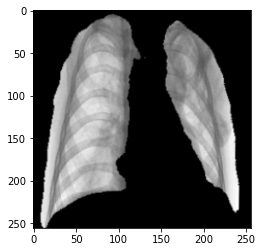

In [14]:
plt.imshow(a[:,:,3], cmap='gray')

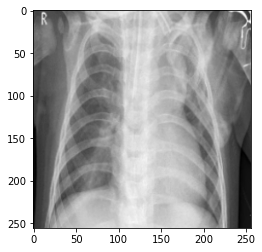

In [15]:
plt.imshow(a[:,:,0], cmap='gray')

## 3 Model training

In [34]:
model = Sequential()
model.add(Conv2D(32, (3,3), padding = "same", input_shape=(IMG_SIZE,IMG_SIZE,4)))
model.add(Activation(activations.relu))
model.add(Conv2D(32, (3,3), padding = "same"))
model.add(Activation(activations.relu))
model.add(MaxPool2D(pool_size = (3, 3)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3,3), padding = "same", input_shape=(IMG_SIZE,IMG_SIZE,4)))
model.add(Activation(activations.relu))
model.add(Conv2D(128, (2,2), padding = "same"))
model.add(Activation(activations.relu))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation(activations.relu))
model.add(Dropout(0.5))
model.add(Dense(512))
model.add(Activation(activations.relu))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer = Adam(learning_rate=0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 256, 256, 32)      1184      
_________________________________________________________________
activation_6 (Activation)    (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 256, 256, 32)      9248      
_________________________________________________________________
activation_7 (Activation)    (None, 256, 256, 32)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 85, 85, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 85, 85, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 85, 85, 64)       

In [35]:
# We can use sklearn for this - see next cell

# weight_for_0 = (1 / len(df_train.loc[df_train['label'] == 0]))*(len(df_train))/2.0 
# weight_for_1 = (1 / len(df_train.loc[df_train['label'] == 1]))*(len(df_train))/2.0
# class_weights = {0: weight_for_0, 1: weight_for_1}

# print('Weight for class 0: {:.2f}'.format(weight_for_0))
# print('Weight for class 1: {:.2f}'.format(weight_for_1))

In [36]:
# Adjust class_weights since we're dealing with imbalanced data here
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(df_train['label']),
                                                 df_train['label'])
class_weights = {0: class_weights[0], 1: class_weights[1]}

In [37]:
class_weights

{0: 1.9448173005219984, 1: 0.6730322580645162}

In [38]:
mcp_save = ModelCheckpoint('models/custom_3008_3.h5', save_best_only=True, monitor='val_loss', mode='min')
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 1, verbose=1,factor=0.1, min_lr=0.000001, min_delta=0.001)
earlystopping = EarlyStopping(monitor='val_accuracy',
                              min_delta=0,
                              patience=1,
                              verbose=0, mode='auto')

In [39]:
history = model.fit(train_generator,
                    validation_data=val_generator,
                    validation_steps=len(val_generator),
                    steps_per_epoch=len(train_generator),
                    epochs=10,
                    class_weight=class_weights,
                    callbacks=[mcp_save, learning_rate_reduction],
                    verbose = True)

Epoch 1/10
163/163 [==============================] - 91s 556ms/step - loss: 0.5554 - accuracy: 0.7030 - val_loss: 0.5873 - val_accuracy: 0.6638
Epoch 2/10
163/163 [==============================] - 91s 557ms/step - loss: 0.3740 - accuracy: 0.8363 - val_loss: 0.4023 - val_accuracy: 0.8190
Epoch 3/10
163/163 [==============================] - 91s 557ms/step - loss: 0.3236 - accuracy: 0.8618 - val_loss: 0.2874 - val_accuracy: 0.8621
Epoch 4/10
163/163 [==============================] - ETA: 0s - loss: 0.2916 - accuracy: 0.8783
Epoch 00004: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
163/163 [==============================] - 88s 543ms/step - loss: 0.2916 - accuracy: 0.8783 - val_loss: 0.3533 - val_accuracy: 0.8621
Epoch 5/10
163/163 [==============================] - ETA: 0s - loss: 0.2584 - accuracy: 0.8947
Epoch 00005: ReduceLROnPlateau reducing learning rate to 1e-06.
163/163 [==============================] - 89s 543ms/step - loss: 0.2584 - accuracy: 0.8947 - v

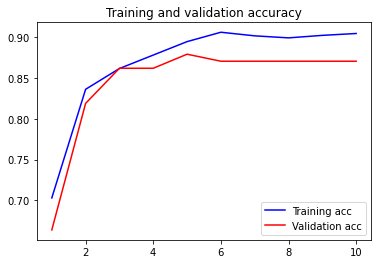

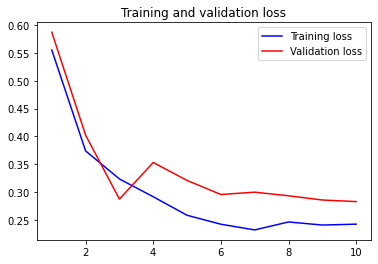

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'blue', label='Training acc')
plt.plot(epochs, val_acc, 'red', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'blue', label='Training loss')
plt.plot(epochs, val_loss, 'red', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## 4 Model evaluation

In [41]:
# model = tf.keras.models.load_model("models/custom_3008_2.h5", compile=True)

In [42]:
df_test.head()

,img,label,mask
0,data/chest-x-ray/test/PNEUMONIA/person1_virus_...,1,data/chest-x-ray/masks/test/PNEUMONIA/person1_...
1,data/chest-x-ray/test/PNEUMONIA/person1622_vir...,1,data/chest-x-ray/masks/test/PNEUMONIA/person16...
2,data/chest-x-ray/test/NORMAL/IM-0030-0001.jpeg,0,data/chest-x-ray/masks/test/NORMAL/IM-0030-000...
3,data/chest-x-ray/test/NORMAL/NORMAL2-IM-0289-0...,0,data/chest-x-ray/masks/test/NORMAL/NORMAL2-IM-...
4,data/chest-x-ray/test/PNEUMONIA/person1_virus_...,1,data/chest-x-ray/masks/test/PNEUMONIA/person1_...


In [43]:
test_generator = TrainDataGenerator4Channels(df_test, False, IMG_SIZE, batch_size=32, shuffle=False)

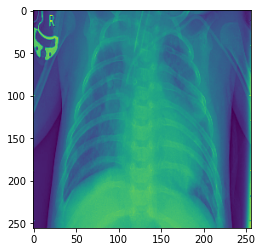

In [44]:
plt.imshow(test_generator.__getitem__(0)[0][0][:,:,0])

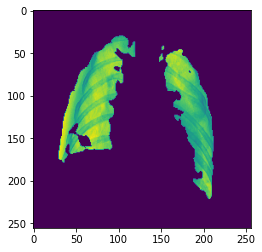

In [45]:
plt.imshow(test_generator.__getitem__(0)[0][0][:,:,3])

In [46]:
model.evaluate(test_generator)

17/17 [==============================] - 6s 359ms/step - loss: 0.2600 - accuracy: 0.8912


[0.25998133420944214, 0.8912213444709778]

## Detail eval

In [47]:
predictions = model.predict(test_generator)

In [48]:
y_true = test_generator.df.label # we can do this since we do not shuffle in test_generator ;)
y_pred = predictions > 0.5

In [49]:
cm = confusion_matrix(y_true, y_pred)

In [50]:
# Snippet taken from - credits to George Fisher
# https://www.kaggle.com/grfiv4/plot-a-confusion-matrix/data
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

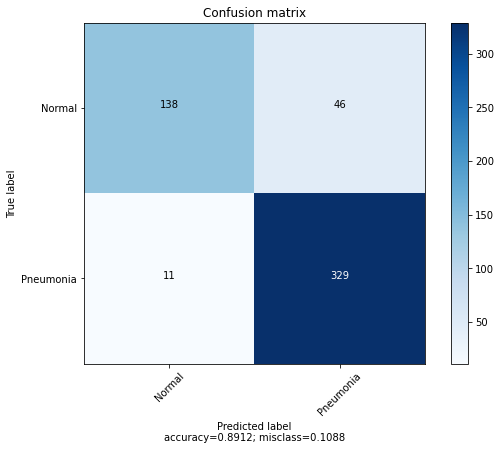

In [51]:
plot_confusion_matrix(cm, ['Normal', 'Pneumonia'], normalize=False)